In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
import datetime
import time
import matplotlib.pyplot as plt

In [ ]:
path = '/news-headlines.tsv'

In [ ]:
def load_data(path):
    data = []
    with open(path, "r") as file:
      lines = csv.reader(file, delimiter='\t')
      for line in lines:
        hdln = line[0]
        data.append(hdln)
    return data

In [ ]:
data = load_data(path)

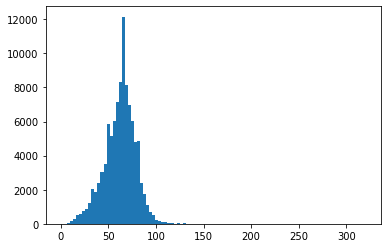

In [ ]:
plt.hist([len(s) for s in data[:100000]], bins=100)
plt.show()

In [ ]:
chars = sorted(set("abcdefghijklmnopqrstuvwxyz0123456789 -,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=()[]{}' ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
chars = list(chars)
EOS = '<EOS>'
UNK = "<UNK>"
PAD = "<PAD>"  # need to move mask to '0'index for Embedding layer
chars.append(UNK)
chars.append(EOS)  #end of sentence
chars.insert(0, PAD)  # now padding should get index of 0

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(chars)}
idx2char = np.array(chars)

def char_idx(c):
  # takes a character and returns an index
  # if character is not in list, returns the unknown token
  if c in chars:
      return char2idx[c]
  
  return char2idx[UNK]

In [ ]:
def tokenize(data, x, numbers):
    padded_data = []
    MAX_LEN = 75  #maximum length of a headline 
    for line in data[x:numbers+x]:
#        print(line)
        cnvrtd = [char_idx(c) for c in line[:-1]]  # convert to number
        if len(cnvrtd) >= MAX_LEN:
            cnvrtd = cnvrtd[0:MAX_LEN-1]
            cnvrtd.append(char2idx[EOS])
        else:
            cnvrtd.append(char2idx[EOS])
            # add padding tokens
            remain = MAX_LEN - len(cnvrtd)
            if remain > 0:
                for i in range(remain):
                    cnvrtd.append(char2idx[PAD])
        padded_data.append(cnvrtd)
    return padded_data
        

In [ ]:
numbers = 20000
x= 0
padded_data= tokenize(data, x,numbers)

In [ ]:
data[200]

'Arizona GOP Congressional Candidate Compares Abortion To Holocaust'

In [ ]:
len(padded_data)

20000

In [ ]:
# now convert to numpy array
np_data = np.array(padded_data)
# for training, we use one character shifted data
np_data_in = np_data[:, :-1]
np_data_out = np_data[:, 1:]

# Create TF dataset
x = tf.data.Dataset.from_tensor_slices((np_data_in, np_data_out))

##################
#### MODELING ####
##################

# Length of the vocabulary in chars
vocab_size = len(chars)

#batch size
BATCH_SIZE=1024

BUFF_SIZE = np_data_in.shape[0]
# create tf.DataSet
x_train = x.shuffle(BUFF_SIZE, reshuffle_each_iteration=True
                   ).batch(BATCH_SIZE, drop_remainder=True)


In [ ]:
for x, y in x_train:
    print(x[0],'\n',y[0])
    break

tf.Tensor(
[49 80 75 76  1 50 68 65  1 32 69 67  1 32 61 63 71 79 72 69 64 95  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0], shape=(74,), dtype=int64) 
 tf.Tensor(
[80 75 76  1 50 68 65  1 32 69 67  1 32 61 63 71 79 72 69 64 95  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0], shape=(74,), dtype=int64)


In [ ]:
#########################
# Positional Encoder
#########################

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])


    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#########################
# Mask Calculations
#########################
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, x)

In [ ]:
#########################
# Attention
#########################
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.wq = tf.keras.layers.Dense(self.head_dim)
        self.wk = tf.keras.layers.Dense(self.head_dim)
        self.wv = tf.keras.layers.Dense(self.head_dim)
        self.dense = tf.keras.layers.Dense(self.embed_size)


    def call(self, v, k, q, mask):
        # Get number of training examples
        batch_size = q.shape[0]

        seq_len_v, seq_len_k, seq_len_q = v.shape[1], k.shape[1], q.shape[1]


        # Split the embedding into self.heads different pieces
        v = tf.reshape(v,(batch_size,seq_len_v, self.heads, self.head_dim))
        k = tf.reshape(k,(batch_size,seq_len_k, self.heads, self.head_dim))
        q = tf.reshape(q,(batch_size,seq_len_q, self.heads, self.head_dim))


        values = self.wv(v)  # (batch_size, value_len, heads, head_dim)
        keys = self.wk(k)  # (batch_size, key_len, heads, head_dim)
        queries = self.wq(q)  # (batch_size, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example

        attention = tf.einsum("nqhd,nkhd->nhqk", queries, keys)
        # queries shape: (batch_size, seq_len_q, heads, heads_dim),
        # keys shape: (batch_size, seq_len_k, heads, heads_dim)
        # attention: (batch_size, heads, seq_len_q, seq_len_k)

         # scale matmul_qk
        dk = tf.cast(tf.shape(keys)[1], tf.float32)
        scaled_attention_logits = attention / tf.math.sqrt(dk)

        # Mask padded indices so their weights become 0

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        # attention shape: (batch_size, heads, seq_len_q, seq_len_k)



        out = tf.einsum("nhql,nlhd->nqhd", attention_weights, values)
        out = tf.reshape(out, (batch_size, seq_len_q, -1))
        # attention shape: (batch_size, heads, seq_len_q, key_len)
        # values shape: (batch_size, seq_len_v, heads, heads_dim)
        # out after matrix multiply: (batch_size, seq_len_q, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.dense(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out, attention_weights

#########################
# Feed Forward Layer
#########################
def point_wise_feed_forward_network(embed_size, feed_forward):
    return tf.keras.Sequential([
        # (batch_size, seq_len, feed_forward)
        tf.keras.layers.Dense(feed_forward, activation='relu'),
        tf.keras.layers.Dense(embed_size)  # (batch_size, seq_len, embed_size)
    ])


In [ ]:
#########################
# Decoder
#########################
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_size, heads, feed_forward, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha = MultiHeadAttention(embed_size, heads)

        self.ffn = point_wise_feed_forward_network(embed_size, feed_forward)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training,look_ahead_mask):
        # enc_output.shape == (batch_size, input_seq_len, embed_size)
        attn, attn_weights_block = self.mha(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, embed_size)
        attn = self.dropout1(attn, training=training)
        out = self.layernorm1(attn + x) # residual

        ffn_output = self.ffn(out)  # (batch_size, target_seq_len, embed_size)
        ffn_output = self.dropout2(ffn_output, training=training)
        # (batch_size, target_seq_len, embed_size)
        out = self.layernorm2(ffn_output + out)

        return out, attn_weights_block
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, embed_size, input_vocab_size, heads, feed_forward,    pe_input, rate=0.1):
    super(Decoder, self).__init__()

    self.embed_size = embed_size
    self.num_layers = num_layers
    self.rate = rate

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, embed_size)    
    self.pos_encoding = positional_encoding(pe_input, embed_size)

    self.dec_layers = [DecoderLayer(embed_size, heads, feed_forward, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training,look_ahead_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.embed_size, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):

      x, block = self.dec_layers[i](x, training, look_ahead_mask)

      attention_weights[f'decoder_layer{i+1}_block'] = block
    # x.shape == (batch_size, target_seq_len, embed_size)
    return x, attention_weights

In [ ]:
##################################################
# Transformer
##################################################
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, embed_size, heads, feed_forward, input_vocab_size, pe_input, rate=0.1):
    super(Transformer, self).__init__()

    self.decoder = Decoder(num_layers, embed_size, input_vocab_size, heads, feed_forward, pe_input, rate)

    self.Final_layer = tf.keras.layers.Dense(input_vocab_size, name='Final_layer')

  def call(self, inp, training):

    look_ahead_mask = create_look_ahead_mask(tf.shape(inp)[1])
    target_padding_mask = create_padding_mask(inp)
    look_ahead_mask = tf.maximum(target_padding_mask, look_ahead_mask)

    output, attention_weights = self.decoder(inp, training, look_ahead_mask)  # (batch_size, inp_seq_len, embed_size)
    out = self.Final_layer(output)

    return out, attention_weights

In [ ]:
num_layers = 4
embed_size = 1024
feed_forward = embed_size
heads = 4
rate = 0.1
input_vocab_size = vocab_size
pe_input = 10000   

In [ ]:
model = Transformer(num_layers, embed_size, heads, feed_forward, input_vocab_size, pe_input, rate=rate)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000005, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
@tf.function
def train_step(inp, tar):
  with tf.GradientTape() as tape:
    output, _ = model(inp, True)
    loss = loss_object(tar, output)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_accuracy.update_state(tar, output)
  return loss

In [ ]:
history = {
  "epoch": [],
  "loss": [],
  "Accuracy": []
}

In [ ]:
EPOCHS = 5
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
#  train_loss.reset_states()
  for (batch, (inp, tar)) in enumerate(x_train):
    batch_loss = train_step(inp, tar)
    total_loss = total_loss+batch_loss
  history['epoch'].append(epoch)
  history['loss'].append(total_loss/(batch+1))
  history['Accuracy'].append(train_accuracy.result())

  if (epoch+1) % 50 == 0:
      ckpt_save_path = ckpt_manager.save()
  if (epoch+1) % 1 == 0:    
    print(f'Epoch {epoch + 1} Loss {total_loss/(batch+1):.4f}, Accuracy: {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

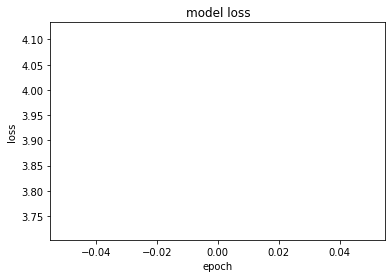

In [ ]:
# Plot 
plt.plot(history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

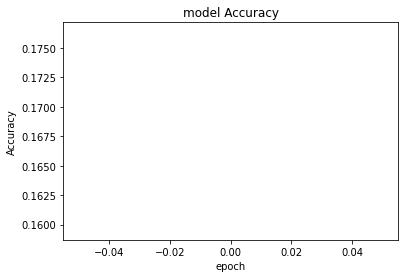

In [ ]:
plt.plot(history['Accuracy'])
plt.title('model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
def generate_text(model, start_string, temperature=0.7, num_generate=35):
  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.

  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  for i in range(num_generate):
      predictions, _ = model(input_eval, False)
      # remove the batch dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predictions = tf.squeeze(predictions, 0)
      # using a categorical distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.concat([input_eval, [[predicted_id]]], axis=-1)
        
      text_generated.append(idx2char[predicted_id])
      # lets break is <EOS> token is generated
      #if idx2char[predicted_id] == EOS:
      #  break #end of a sentence reached, lets stop

  return (start_string + ''.join(text_generated))

In [ ]:
print(generate_text(model, start_string=u"Arizona"))

Arizonatts ltcreOtr io <PAD><PAD><PAD>e ees S eero  <PAD><PAD>
